In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.0 MB/s 
     |████████████████████████████████| 9.9 MB 42.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


# Importing Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as sp
import seaborn as sns

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

from sklearn.linear_model import LinearRegression as lm
import statsmodels.api as sm

Defining the functions

In [ ]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return (diff)

In [ ]:
def runMyAR1(yin):
    tlen = len(yin)
    y = np.array(yin[2:tlen])
    x = np.array(yin[1:(tlen-1)])
    X = x
    X = sm.add_constant(X)
    regr2 = sm.OLS(y,X)
    model = regr2.fit()
    print(model.summary())
    ypred = model.predict()
    plt.plot((y-ypred))

In [ ]:
# Create large images!
register_matplotlib_converters()
sns.set_style("darkgrid")
plt.rc("figure", figsize=(14, 8)) # was 16,12
plt.rc("font", size=13)

Importing Data

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/DS Aegis/Time Series Adv Stats/All 3 models on datasets/Cali Emissions.csv')

In [ ]:
df.head()

,Unnamed: 0,"Total carbon dioxide emissions from all sectors, all fuels, California (million metric tons CO2)"
0,1980,346.183721
1,1981,334.381538
2,1982,298.004398
3,1983,293.436371
4,1984,315.858105


In [ ]:
df.rename(columns={'Unnamed: 0':'Year','Total carbon dioxide emissions from all sectors, all fuels, California (million metric tons CO2)':'MMT'}, inplace=True)
df.head()

,Year,MMT
0,1980,346.183721
1,1981,334.381538
2,1982,298.004398
3,1983,293.436371
4,1984,315.858105


lets see the original dataset then we will split into train and test

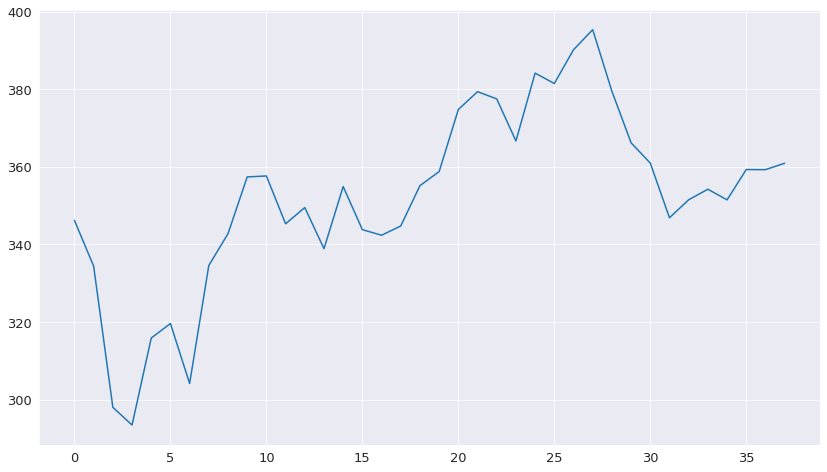

In [ ]:
plt.plot(df['MMT'])

----------------------------------------------------------------------------
- We can see mix trend in the dataset but its increasing for sure
- Variance is also significant
- Seasonality seems to be there but not so vibrant but lets decide it on the basis decomposition charts
----------------------------------------------------------------------------

Splitting the dataset into train and test

In [ ]:
df.shape

(38, 2)

In [ ]:
df=df['MMT']

In [ ]:
n=int(df.shape[0]*0.7) #test size=30% data
train=df.iloc[:n]
test=df.iloc[n:]


In [ ]:
train.shape

(26,)

In [ ]:
test.shape

(12,)

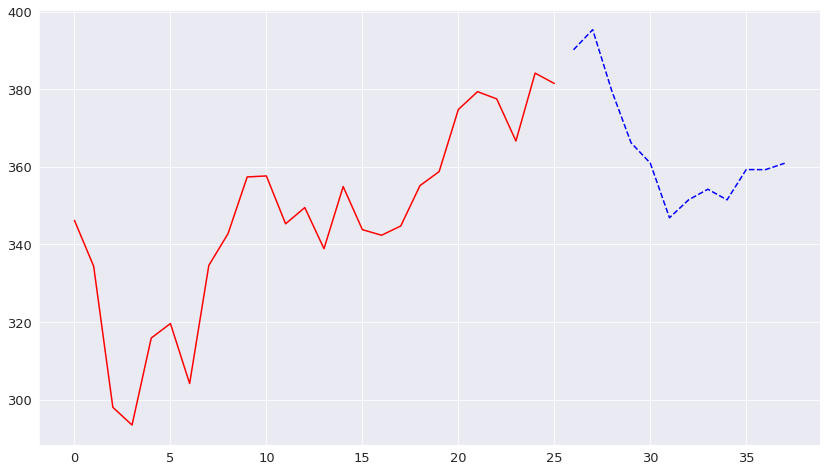

In [ ]:
plt.plot(train,'r')
plt.plot(test,'b--')

Lets perform ADF test of stationarity on the train data

**Adfuller**


- **Null hypothesis**: Non Stationarity exists in the series.

- **Alternative Hypothesis**: Stationarity exists in the series

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
def dicky_fuller_test(df):
    result = adfuller(df)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1]>0.05:
        print("Fail to reject the null hypothesis (H0), the data is non-stationary")
    else:
        print("Reject the null hypothesis (H0), the data is stationary.")

In [ ]:
dicky_fuller_test(df)

ADF Statistic: -1.604382
p-value: 0.481392
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610
Fail to reject the null hypothesis (H0), the data is non-stationary


In [ ]:
dicky_fuller_test(train)

ADF Statistic: -1.063370
p-value: 0.729456
Critical Values:
	1%: -3.724
	5%: -2.986
	10%: -2.633
Fail to reject the null hypothesis (H0), the data is non-stationary


- We can conclude that the data is non stationary as p- value is significantly greater than 0.05. 
- It means our initial observation was corrent that the data has varing mean and variance with time 

In [ ]:
# lets decompose our Time series into its components

In [ ]:
from statsmodels.tsa.seasonal import STL
stl = STL(train, period=12)

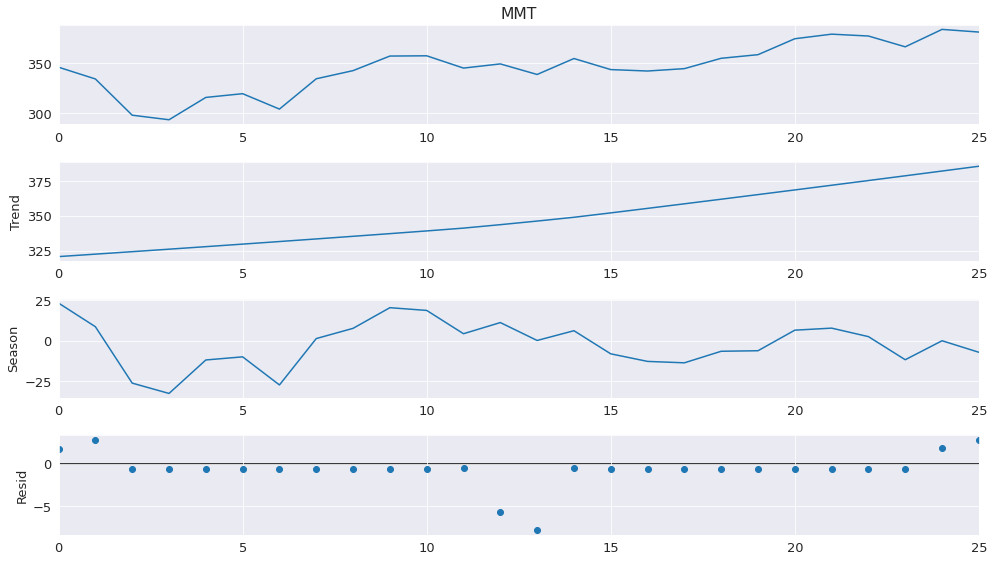

In [ ]:
res = stl.fit()
fig = res.plot()

- There is gradual increase in trend
- some pattern can be seen in Seasonality so our initial observation was correct
- residuals are also random

lets transform the data by differencing method to get rid of trend

In [ ]:
df_diff1 = difference(train, interval=1)

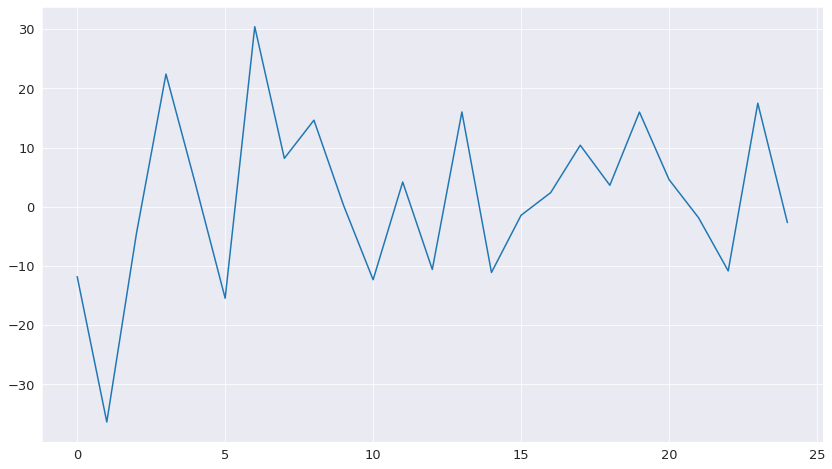

In [ ]:
plt.plot(df_diff1)

we have de trended the data....lets check ADFuller test and the average of the detrended data

In [ ]:
dicky_fuller_test(df_diff1) # we get stationary data after first differencing itself

ADF Statistic: -4.888183
p-value: 0.000037
Critical Values:
	1%: -3.738
	5%: -2.992
	10%: -2.636
Reject the null hypothesis (H0), the data is stationary.


In [ ]:
#lets see if are further able to reduce by differencing
df_diff2 = difference(df_diff1, interval=1) # de seasonalizing as its yearly data we would see year to year change so interval=1

As we can see we get better results by differencing twice

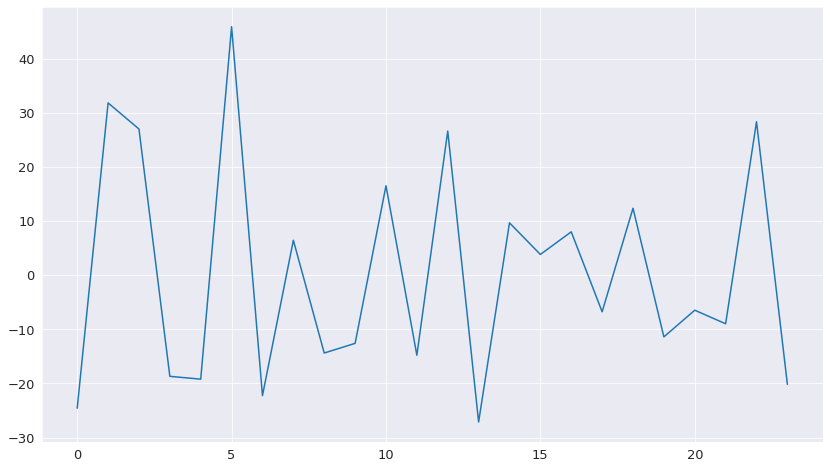

In [ ]:
plt.plot(df_diff2)

In [ ]:
# lets check wheather our data has now become stationary or not using ADF test
dicky_fuller_test(df_diff2)

ADF Statistic: -8.183461
p-value: 0.000000
Critical Values:
	1%: -3.753
	5%: -2.998
	10%: -2.639
Reject the null hypothesis (H0), the data is stationary.


-----------------------------------------------------------------------------
Since, the data is now stationary, we will plot ACF-PACF plots to get the neccessary parameters of ARIMA model


**ACF-PACF Plots**

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


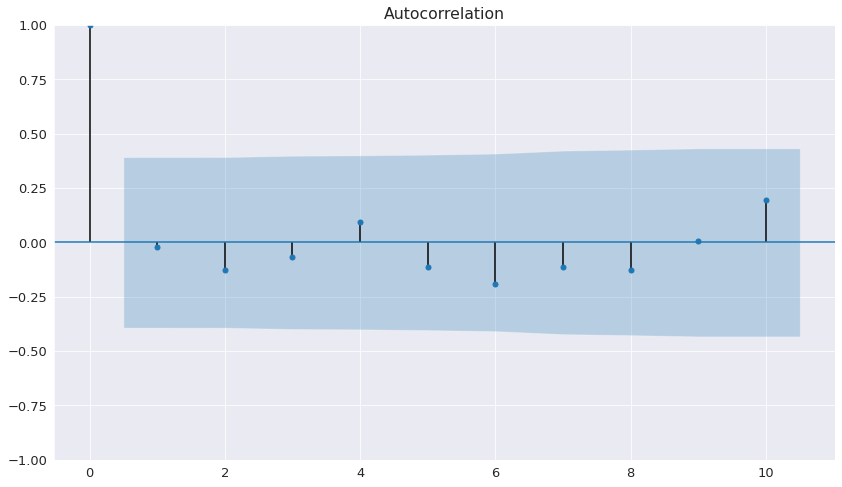

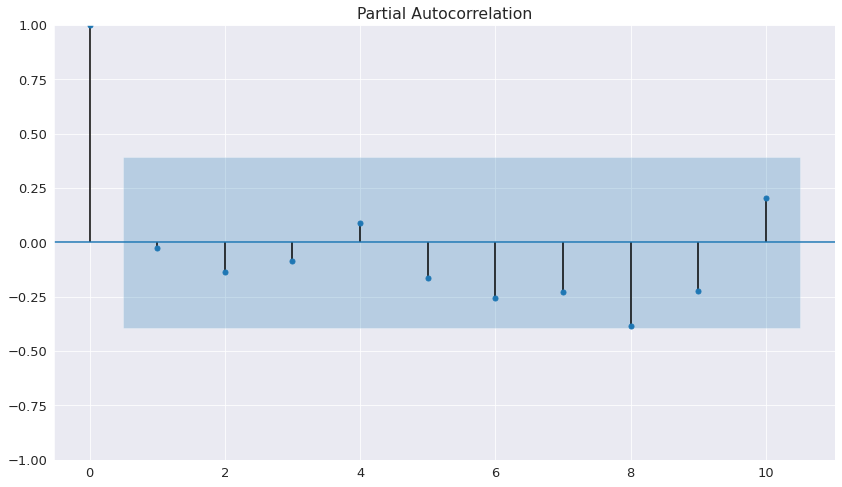

In [ ]:
#plotting acf and pacf

fig1 = sm.graphics.tsa.plot_acf(df_diff1,lags=10)
fig2 = sm.graphics.tsa.plot_pacf(df_diff1,lags=10)

**Observations**
- From PACF plot we can say that p=0 and we can also notice that tails are off almost which suggest geometric decay
- From ACF plot q=0 
- this means there is not auto correlation with lags and it means our time series is random 
- d value would be 2 as we have differenced twice to make the series stationary
- In SARIMA model P,D,Q,s , D=1 as certain seasonality present in the series


In [ ]:
# Applying ARIMA
my_model = sm.tsa.arima.ARIMA(train, order=(0,1,0),seasonal_order=(0,0,0,0)) # p=0,q=0 as time series is random as per ACF and PACF plots 
my_model_res = my_model.fit()
print(my_model_res.summary())

                               SARIMAX Results                                
Dep. Variable:                    MMT   No. Observations:                   26
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -101.572
Date:                Sun, 20 Nov 2022   AIC                            205.144
Time:                        11:47:06   BIC                            206.363
Sample:                             0   HQIC                           205.482
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       197.9491     51.545      3.840      0.000      96.922     298.976
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.69
Prob(Q):                              0.90   Pr

- its intresting to notice that if we add seasonal component to aur model, AIC-bic values start dropping but model prediction of the train data starts hampering 

In [ ]:
pred_no=test.shape[0]
pred_no

12

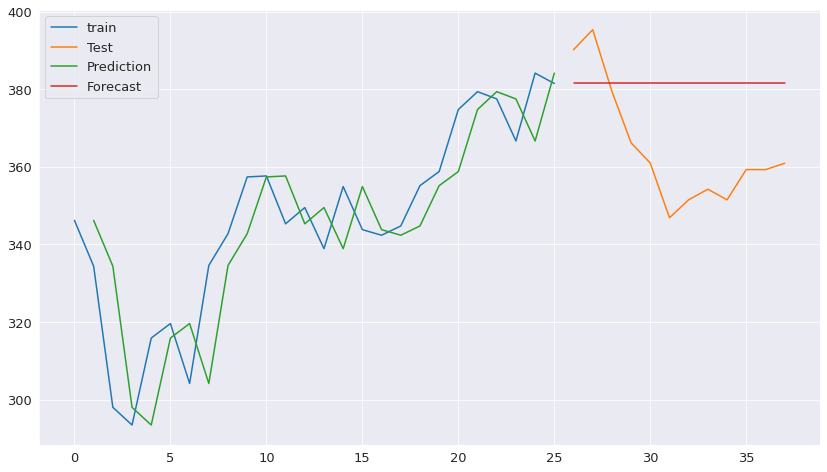

In [ ]:
#predicting and forecast on train and test data

tspredict= my_model_res.predict(1)

tsforecast=my_model_res.forecast(pred_no)

plt.plot(train,label='train')
plt.plot(test,label='Test')
plt.plot(tspredict,label='Prediction')
plt.plot(tsforecast,label='Forecast')
plt.legend()

- The predictions are good which means our model is able to capture the data properly
- Forecast is just an straight trend because seasonality wasn’t taken into consideration.
- we get low aic-bic values by adding seasonal component to our model but it would be great to see how it is creating difference in predictions

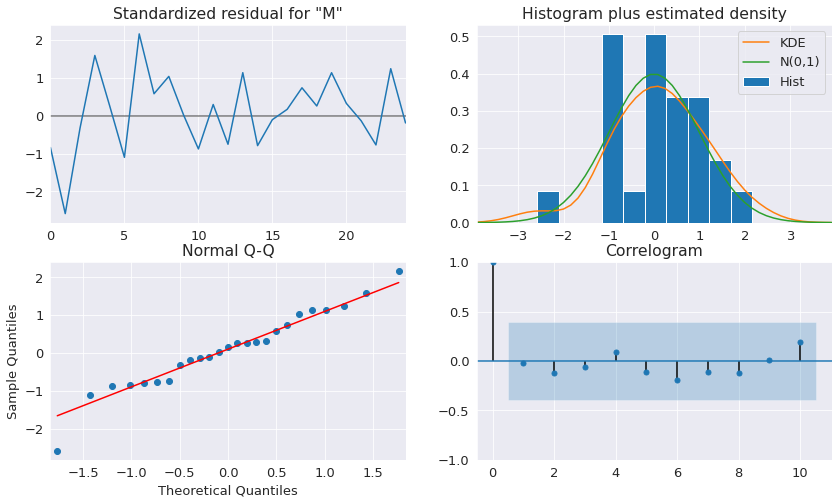

In [ ]:
pred = my_model_res.plot_diagnostics()

### Observations

- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself and hence their mean is zero.

- The KDE plot of the residuals on the top right shows a kind of similar plot as a normal distribution.

- From the normal Q-Q plot, one can infer that we almost have a straight line, which suggests no systematic departure from normality. 



Evaluation metrics-rmse

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
test.shape

(12,)

In [ ]:
rmse = mean_squared_error(test, tsforecast, squared=False)
rmse

22.496572703045484

In [ ]:
tsforecast.describe()

count     12.000000
mean     381.471792
std        0.000000
min      381.471792
25%      381.471792
50%      381.471792
75%      381.471792
max      381.471792
Name: predicted_mean, dtype: float64

Model 2-Just for understanding

In [ ]:
# Applying ARIMA
my_model = sm.tsa.arima.ARIMA(train, order=(0,1,0),seasonal_order=(0,1,0,12)) # p=0,q=0 as time series is random as per ACF and PACF plots 
my_model_res = my_model.fit()
print(my_model_res.summary())

                                    SARIMAX Results                                     
Dep. Variable:                              MMT   No. Observations:                   26
Model:             ARIMA(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 -57.334
Date:                          Sun, 20 Nov 2022   AIC                            116.668
Time:                                  11:47:07   BIC                            117.233
Sample:                                       0   HQIC                           116.552
                                           - 26                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       396.4533    120.305      3.295      0.001     160.659     632.247
Ljung-Box (L1) (Q):                   0.72   Jarque

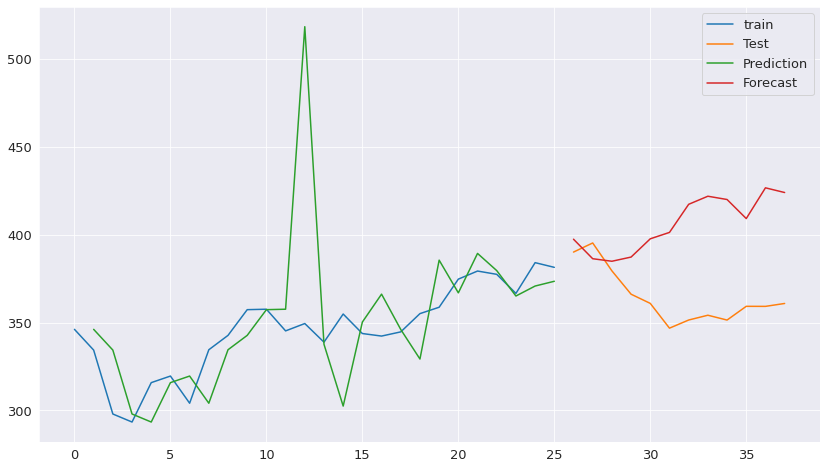

In [ ]:
tspredict= my_model_res.predict(1)

tsforecast=my_model_res.forecast(pred_no)

plt.plot(train,label='train')
plt.plot(test,label='Test')
plt.plot(tspredict,label='Prediction')
plt.plot(tsforecast,label='Forecast')
plt.legend()

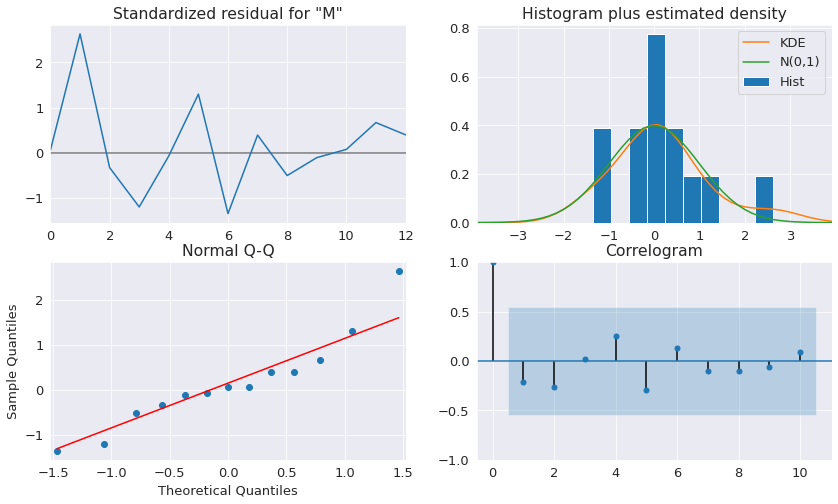

In [ ]:
pred = my_model_res.plot_diagnostics()

In [ ]:
rmse = mean_squared_error(test, tsforecast, squared=False)
rmse

49.65954394591276

Though we observe differnece in graphs of forecast, there is no change in the rmse value, which means the average is same for both the forecast

# **Auto-Arima**

In [ ]:
from pmdarima import auto_arima

In [ ]:
arima_model = auto_arima(train,start_p=0, d=1, start_q=0,max_p=5, max_d=5, max_q=5,
                        error_action="ignore",trace = True,
                         suppress_warnings=True,stepwise = True,
                         random_state=369,n_fits= 50 )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=206.891, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=208.877, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=208.872, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=205.144, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.244 seconds


In [ ]:
print(arima_model.summary())-

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   26
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -101.572
Date:                Sun, 20 Nov 2022   AIC                            205.144
Time:                        11:47:10   BIC                            206.363
Sample:                             0   HQIC                           205.482
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       197.9491     51.545      3.840      0.000      96.922     298.976
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.69
Prob(Q):                              0.90   Pr

## Forecasting using Auto ARIMA

In [ ]:
forecast =pd.DataFrame(arima_model.predict(n_periods=119),columns=['forecast'],index=test.index)
forecast

,forecast
26,381.471792
27,381.471792
28,381.471792
29,381.471792
30,381.471792
31,381.471792
32,381.471792
33,381.471792
34,381.471792
35,381.471792


In [ ]:
forecast_df =pd.DataFrame(arima_model.predict(n_periods=12),columns=['forecast'],index=test.index)
forecast_df=pd.concat([forecast, test],axis=1)
forecast_df

,forecast,MMT
26,381.471792,390.164017
27,381.471792,395.340927
28,381.471792,379.480916
29,381.471792,366.184902
30,381.471792,360.953079
31,381.471792,346.864178
32,381.471792,351.496006
33,381.471792,354.219000
34,381.471792,351.477053
35,381.471792,359.290429


In [ ]:
forecast_df.describe()

,forecast,MMT
count,12.000000,12.000000
mean,381.471792,364.637155
std,0.000000,15.586384
min,381.471792,346.864178
25%,381.471792,353.538252
50%,381.471792,360.101959
75%,381.471792,369.508906
max,381.471792,395.340927


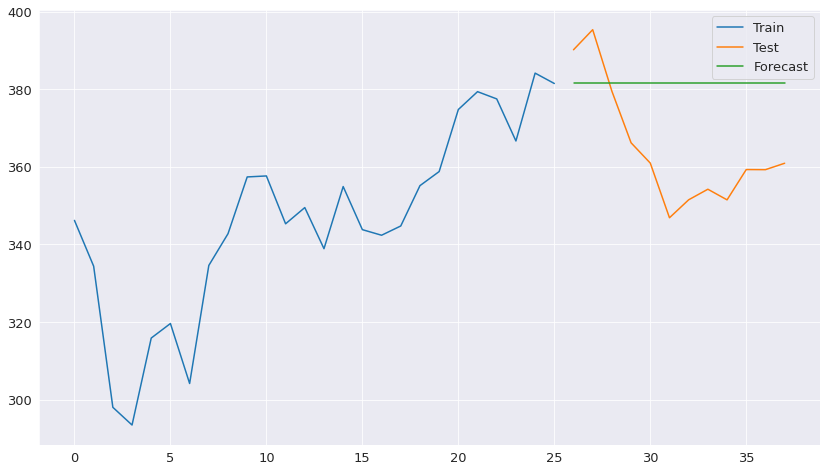

In [ ]:
#plotting the graph

plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(forecast,label='Forecast')
#plt.plot(tsforecast,label='Forecast')
plt.legend()

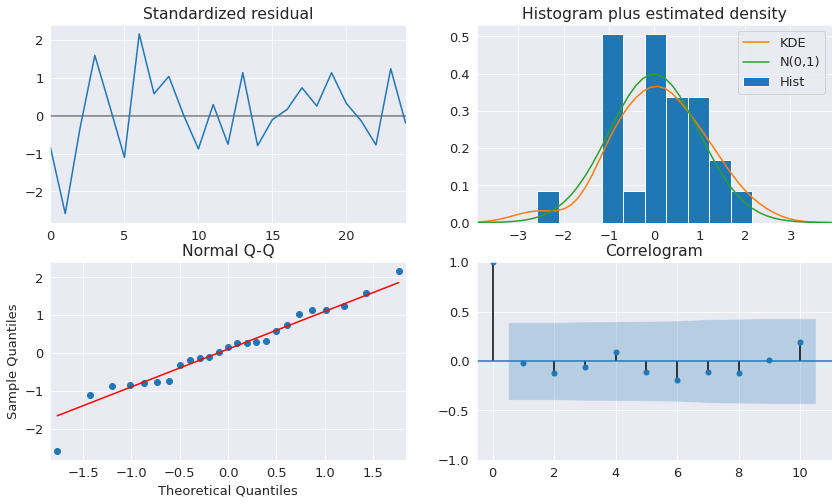

In [ ]:
#plotting diagnostics

d= arima_model.plot_diagnostics()

Since our ARIMA model parameters p,d,q=(0,1,0) are same as that AUTO_ARIMA parameters we have got the exact same results 

In [ ]:
rms = np.sqrt(mean_squared_error(test,forecast_df['forecast'])) # same as squared=False
print('Rmse value:',rms) 

Rmse value: 22.496572703045484


# **Holt-Winter**

In [ ]:
from statsmodels.tsa.holtwinters import Holt # since we only have trend in our data we will apply Holt's model

In [ ]:
model = Holt(train)
result = model.fit()
result.params

{'smoothing_level': 0.9658393053136897,
 'smoothing_trend': 5.312941772105741e-07,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 344.2508195887798,
 'initial_trend': 1.4362668560277583,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [ ]:
print(result.summary())

                              Holt Model Results                              
Dep. Variable:                    MMT   No. Observations:                   26
Model:                           Holt   SSE                           4894.350
Optimized:                       True   AIC                            144.181
Trend:                       Additive   BIC                            149.214
Seasonal:                        None   AICC                           148.602
Seasonal Periods:                None   Date:                 Sun, 20 Nov 2022
Box-Cox:                        False   Time:                         11:47:11
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9658393                alpha                 True
smoothing_trend           5.3129e-07                

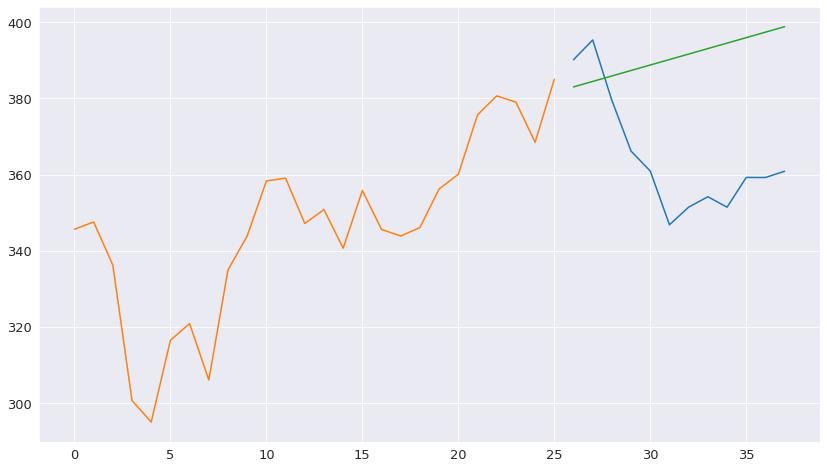

In [ ]:
plt.plot(test)
plt.plot(result.fittedvalues)
plt.plot(result.forecast(12))

In [ ]:
rmse = mean_squared_error(test, result.forecast(pred_no), squared=False)
rmse

32.30365341716019

- As rmse value of holt winters model is 32.3 which is lower than rmse value of ARIMA(49.57) Model, therefore we can say that for this scenario Holt-Winter model fits better 

In [ ]:
# lets also check manually 

In [ ]:
rolling = df.rolling(10) # moving average with window 10
type(rolling)

pandas.core.window.rolling.Rolling

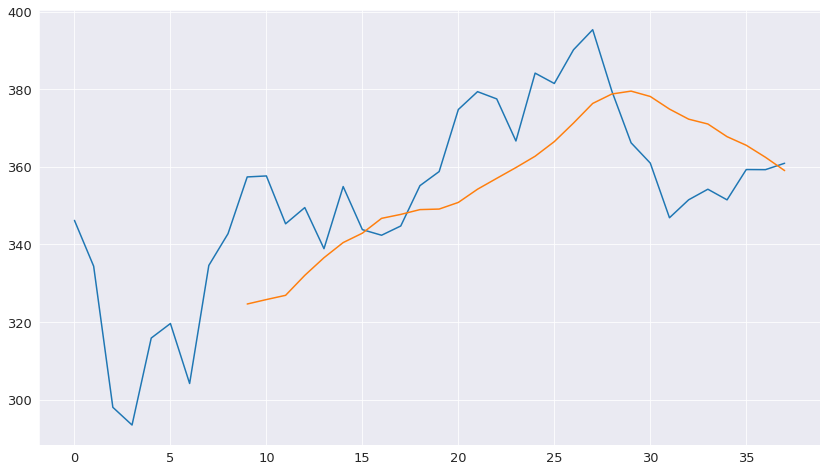

In [ ]:
mavg = rolling.mean()
plt.plot(df)
plt.plot(mavg)

In [ ]:
# Exponentially Weighted Moving Average or Exponential smoothing

In [ ]:
n=1/(2*12)
n

0.041666666666666664

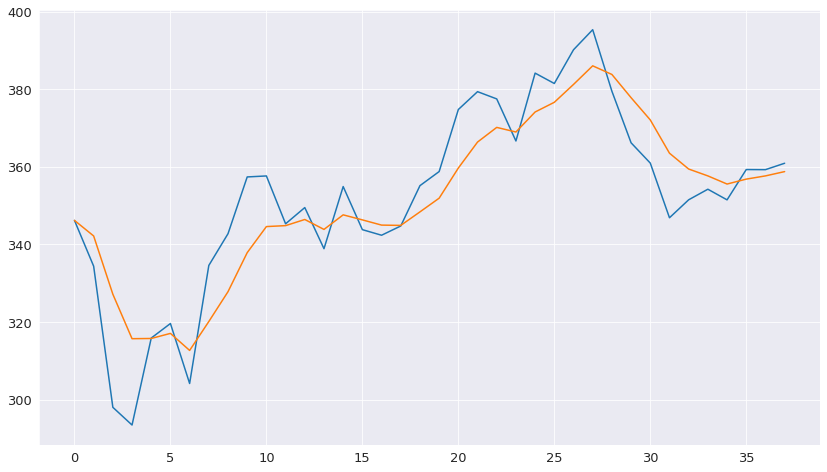

In [ ]:
# Try out the following with various values of 'alpha' and evaluate the results
ewma = df.ewm(alpha=0.34, adjust=False).mean() # as we increase alpha value our smoothing curve follows original curve # at 0.9 value it almost matches the original curve
                                              # as we decrease alpha value more smooth curve we get and less it follows original curve
plt.plot(df)
plt.plot(ewma)

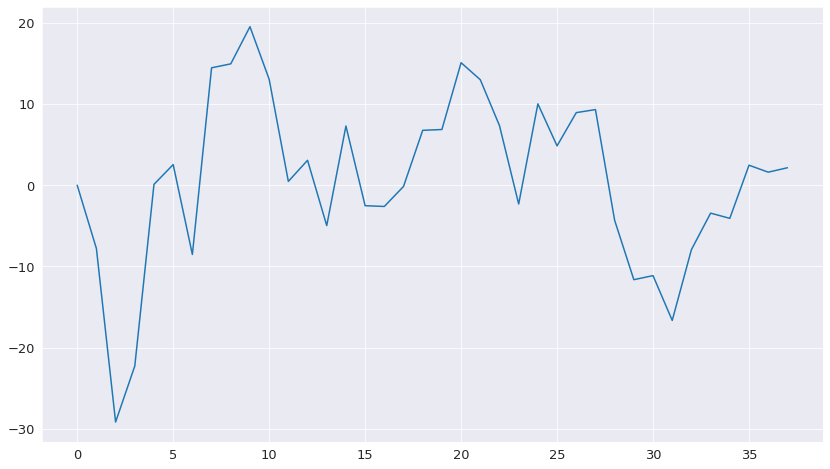

In [ ]:
plt.plot(df-ewma) # differencing transformation resulting to de-trended series

Lets apply Holt-Winter manually step by step

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [ ]:
ses = SimpleExpSmoothing(train) # moving average

In [ ]:
result = ses.fit(smoothing_level=0.3, optimized=False)

In [ ]:
print(result.summary())

                       SimpleExpSmoothing Model Results                       
Dep. Variable:                    MMT   No. Observations:                   26
Model:             SimpleExpSmoothing   SSE                           7922.492
Optimized:                      False   AIC                            152.703
Trend:                           None   BIC                            155.220
Seasonal:                        None   AICC                           154.608
Seasonal Periods:                None   Date:                 Sun, 20 Nov 2022
Box-Cox:                        False   Time:                         11:47:13
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.3000000                alpha                False
initial_level              346.18372                

In [ ]:
mypred = result.predict(start=1, end=40)

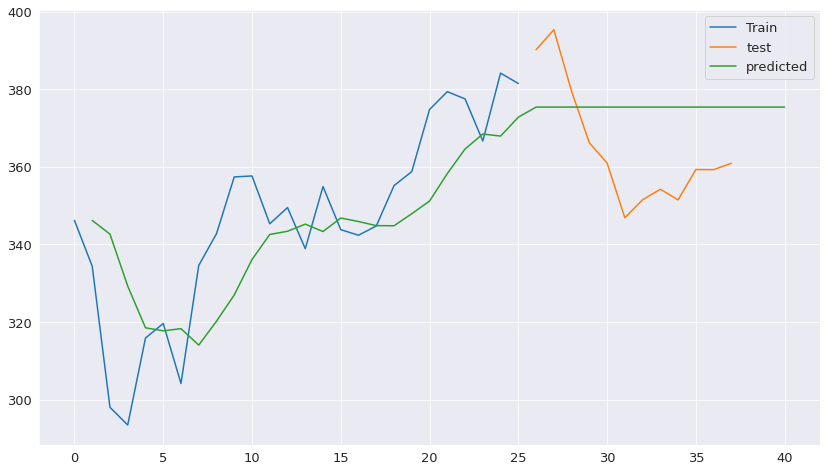

In [ ]:
plt.plot(train, label='Train')
plt.plot(test, label='test')
plt.plot(mypred, label='predicted')
plt.legend()

In [ ]:
result.params

{'smoothing_level': 0.3,
 'smoothing_trend': None,
 'smoothing_seasonal': None,
 'damping_trend': nan,
 'initial_level': 346.183721,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

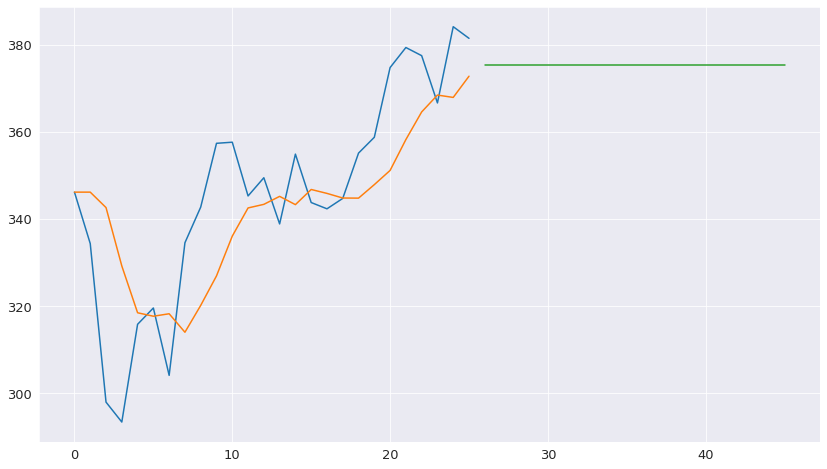

In [ ]:
plt.plot(train)
plt.plot(result.fittedvalues)
plt.plot(result.forecast(20))

exp smoothing


In [ ]:
# Holt's linear trend values

In [ ]:
from statsmodels.tsa.holtwinters import Holt

In [ ]:
model = Holt(train, exponential=True)
result = model.fit()
result.params

{'smoothing_level': 0.9658346797584936,
 'smoothing_trend': 1.2080592333167515e-08,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 344.45222629173753,
 'initial_trend': 1.0035991319103599,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [ ]:
print(result.summary())

                              Holt Model Results                              
Dep. Variable:                    MMT   No. Observations:                   26
Model:                           Holt   SSE                           4908.153
Optimized:                       True   AIC                            144.254
Trend:                 Multiplicative   BIC                            149.287
Seasonal:                        None   AICC                           148.676
Seasonal Periods:                None   Date:                 Sun, 20 Nov 2022
Box-Cox:                        False   Time:                         11:47:14
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9658347                alpha                 True
smoothing_trend           1.2081e-08                

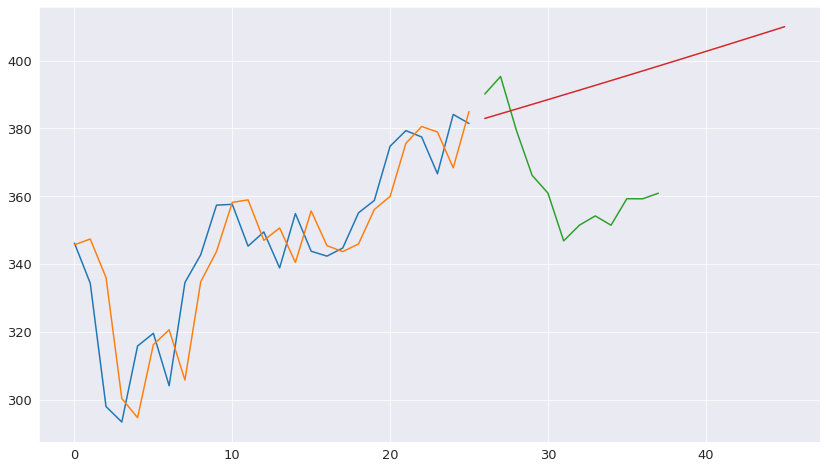

In [ ]:
plt.plot(train)
plt.plot(result.fittedvalues)
plt.plot(test)
plt.plot(result.forecast(20))

If we keep the test size to be 20% we get better result in Holt's model as compared to ARIMA as holt model predicts the values as increasing trend and not a flat line 

In [ ]:
rmse = mean_squared_error(test, result.forecast(pred_no), squared=False)
rmse

32.004045264910914

We get slight less rmse when we keep exponential parameter as True